In [2]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, random
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

In [3]:
datafolder = r"/home/jiyongso/jhjeon/multiplicity"

fn_pref = 'C1_1'
# Original ptrac file name. For memory.
file0 = fn_pref+'.p'

# file0 로부터 필요한 결과만 추출하여 정리한 파일의 이름들.
fn_carbon = fn_pref+'_carbon.o'
fn_proton = fn_pref+'_proton.o'
fn_photoelectric = fn_pref+'_photoelectric.o'
file_compton = fn_pref+'_compton.o'




In [3]:
def endp(x):
    return x.endswith(".p")

def get_pfile_names(dirpath):
    _, _, filelist = next(os.walk(dirpath))
    
    return list(filter(endp, filelist))
    
def ptrac_anaysis1(fn):
    """
    Carbon, Proton, Photoelectron, Compton
    """
    l_carbon=[]
    l_proton=[]
    l_photoelectric=[]
    l_compton = []
    h=1
    status = {"carbon" : False, "proton" : False, "electron" : False, "compton" : False}
    with open(os.path.join(datafolder, fn)) as ff:
        for ln, line1 in enumerate(ff):
#             if ln > 2000:
#                 break
            if ln < 14:
                continue
            if ln == 14 :
                print(line1) 
            
            l1 = line1.split()
            if len(l1)< 7 :
                # start line of history
                if l1[1] == '1000' :
                    h+=1
                    continue
            else :
                line2 = next(ff)
                l2 = line2.split()
            
            ### carbon scattering
            if l1[2] == '6000' and l1[4] == '1':  
                l_carbon.append([float(l2[8]), int(l1[5]), h])
                
            ### proton production
            if status["proton"] and l1[4] == '9':  
                l_proton.append([float(l2[8]), int(l1[5]), h])     
                            
            if l1[0] == '2030' :
                status["proton"] = True
            else :
                status["proton"] = False
            
            ### electron production
            
            if status["electron"] and l1[4] == '3': 
                l_photoelectric.append([float(l2[8]), int(l1[5]), h])
 
            if l1[0] == '2011' and l1[4] == '2' :
                status["electron"] = True
            else :
                status["electron"] = False
            
            ### compton scattering
 
            if status["compton"] and l1[4] == '3':
                l_compton.append([float(l2[8]) , int(l1[5]), int(h)])       
            
            if l1[0] == '2012' and l1[4] == '2':
                status["compton"] = True
            else :
                status["compton"] = False
            
                
        df_carbon = pd.DataFrame({"time": [ll[0] for ll in l_carbon], 
                               "cell" : [ll[1] for ll in l_carbon], 
                               "Nhist": [ll[2] for ll in l_carbon]})
        df_proton = pd.DataFrame({"time": [ll[0] for ll in l_proton], 
                               "cell" : [ll[1] for ll in l_proton], 
                               "Nhist": [ll[2] for ll in l_proton]})
        df_photoelectric = pd.DataFrame({"time": [ll[0] for ll in l_photoelectric], 
                               "cell" : [ll[1] for ll in l_photoelectric], 
                               "Nhist": [ll[2] for ll in l_photoelectric]})
        df_compton = pd.DataFrame({"time": [ll[0] for ll in l_compton], 
                               "cell" : [ll[1] for ll in l_compton], 
                               "Nhist": [ll[2] for ll in l_compton]})
        
        
        
        return df_carbon, df_proton, df_photoelectric, df_compton

def ptrac_anaysis2(fn):
    """
    Neutron, photon(gamma)
    """
    
    l_neutron=[]
    l_photon=[]

    h=1
    status = {"carbon" : False, "proton" : False, "electron" : False, "compton" : False}
    with open(os.path.join(datafolder, fn)) as ff:
        for ln, line1 in enumerate(ff):
#             if ln > 2000:
#                 break
            if ln < 14:
                continue
            if ln == 14 :
                print(line1) 
            
            l1 = line1.split()
            if len(l1)< 7 :
                # start line of history
                if l1[1] == '1000' :
                    h+=1
                    continue
            else :
                line2 = next(ff)
                l2 = line2.split()
            
            ### carbon scattering
            if l1[2] == '6000' and l1[4] == '1':  
                l_neutron.append([float(l2[8]), int(l1[5]), h])
                
            ### proton production
            if status["proton"] and l1[4] == '9':  
                l_neutron.append([float(l2[8]), int(l1[5]), h])     
                            
            if l1[0] == '2030' :
                status["proton"] = True
            else :
                status["proton"] = False
            
            ### electron production
            
            if status["electron"] and l1[4] == '3': 
                l_photon.append([float(l2[8]), int(l1[5]), h])
 
            if l1[0] == '2011' and l1[4] == '2' :
                status["electron"] = True
            else :
                status["electron"] = False
            
            ### compton scattering
 
            if status["compton"] and l1[4] == '3':
                l_photon.append([float(l2[8]) , int(l1[5]), int(h)])       
            
            if l1[0] == '2012' and l1[4] == '2':
                status["compton"] = True
            else :
                status["compton"] = False
            
                
        df_neutron = pd.DataFrame({"time": [ll[0] for ll in l_neutron], 
                               "cell" : [ll[1] for ll in l_neutron], 
                               "Nhist": [ll[2] for ll in l_neutron]})
        df_photon = pd.DataFrame({"time": [ll[0] for ll in l_photon], 
                               "cell" : [ll[1] for ll in l_photon], 
                               "Nhist": [ll[2] for ll in l_photon]})
        
        
        return df_neutron, df_photon
    
def ptrac_reduce(df):
    return df.drop_duplicates(subset=["cell", "Nhist"], keep="first")


def ptrac_combine(inid, tid):
    prefix="C"+str(inid)+"_"+str(tid)
    fn = prefix+".p"
    ln, lp = ptrac_anaysis2(fn)
    lnr=ptrac_reduce(ln)
    lpr=ptrac_reduce(lp)
    
    return (prefix, lnr, lpr)

def ptrac_combine_save(inid, tid):
    prefix, lnr, lpr = ptrac_combine(inid, tid)
    lnr.to_pickle(prefix+"_neutron.pkl")
    lpr.to_pickle(prefix+"_photon.pkl")

def combine_all(num=1):
    prefix="C"+str(num)+"_"
    finalresult = {}

    for i in range(1, 11):
        fn = prefix+str(i)+".p"
        print(fn+" start.")
        ln, lp = ptrac_anaysis2(fn)
        finalresult[prefix+str(i)+"_neutron"]=ptrac_reduce(ln)
        finalresult[prefix+str(i)+"_photon"]=ptrac_reduce(lp)

    return finalresult





In [82]:
t1=time.time()
lca, lpr, lph, lcp=ptrac_anaysis1(file0)
print(time.time()-t1)

          3      1000         0         8  1.00000E+00

77.12720322608948


In [50]:
t1=time.time()
ln, lp = ptrac_anaysis2(file0)
print(time.time()-t1)

In [8]:
t1=time.time()
ptrac_combine_save(1, 3)
print(time.time()-t1)

          3      1000         0         8  1.00000E+00

1249.073888540268


In [9]:
for i in range (4, 11):
    t1=time.time()
    ptrac_combine_save(1, i)
    print(time.time()-t1)

          1      1000         0         8  1.00000E+00

1304.7726390361786
          3      1000         0         8  1.00000E+00

1395.1680355072021
          1      1000         0         8  1.00000E+00

1501.0007464885712
          2      1000         0         8  1.00000E+00

1541.7056803703308
          1      1000         0         8  1.00000E+00

1621.9005949497223
          3      1000         0         8  1.00000E+00

1701.4434967041016
          1      1000         0         8  1.00000E+00

1788.7790625095367


In [5]:
c1ingot={}
for i in range(1, 11):
    nname="C1_"+str(i)+"_neutron"
    pname="C1_"+str(i)+"_photon"
    c1ingot[nname]=pd.read_pickle(nname+".pkl")
    c1ingot[pname]=pd.read_pickle(pname+".pkl")

In [6]:
c1ingot

{'C1_1_neutron':            time  cell  Nhist
 0       1.45420   243      2
 1       0.83894   329      5
 2       1.56780   323      6
 3       2.15450   322      6
 4       8.91700   122      6
 ...         ...   ...    ...
 49917  15.59600   322  43687
 49919   0.53151   126  43688
 49922   1.94390   126  43689
 49923   0.80820   122  43690
 49924   1.48290   125  43690
 
 [30507 rows x 3 columns],
 'C1_1_photon':              time  cell  Nhist
 0        0.170020     1      2
 27       0.806250     1      3
 51       0.139780     1      4
 78       0.263320     1      5
 105      1.378800     1      6
 ...           ...   ...    ...
 1414396  0.755870     1  43686
 1414407  0.053298     1  43687
 1414468  1.023600     1  43688
 1414483  0.147330     1  43689
 1414504  0.012935     1  43690
 
 [46199 rows x 3 columns],
 'C1_2_neutron':            time  cell  Nhist
 0       0.72268   128      2
 1      11.85200   127      3
 2      83.06000   122      3
 3       9.38910   243      5
 

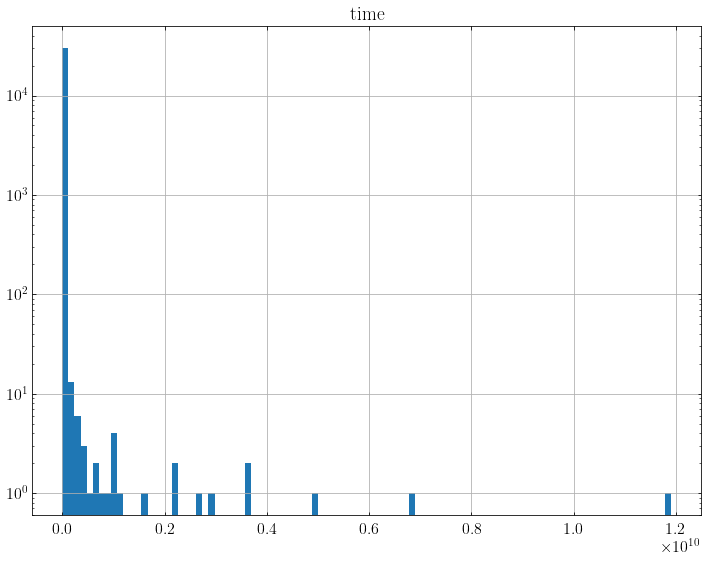

In [7]:
ln2.hist("time", bins=100)
plt.yscale('log')

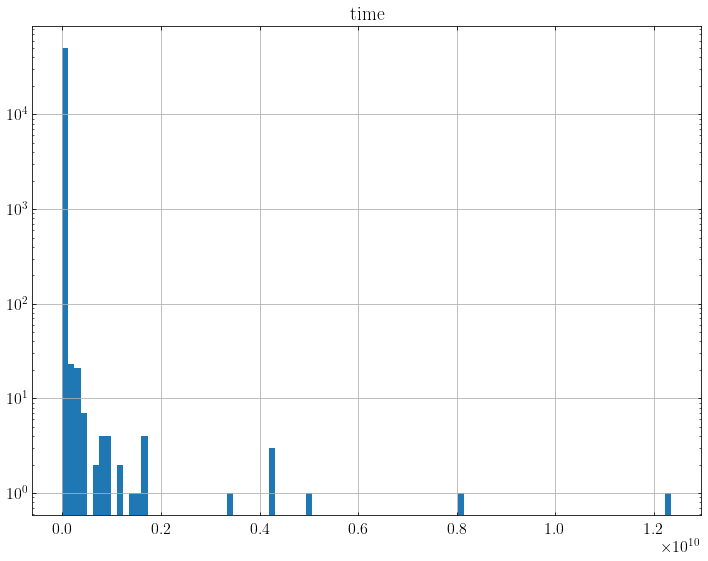

In [73]:
ln.hist("time", bins=100)
plt.yscale('log')

In [74]:
ln.time.max()

12348000000.0

In [41]:
def endp(x):
    return x.endswith(".p")
pfiles = list(filter(endp, filelist))
str1=""
for pfile in pfiles :
    f1=open(os.path.join(datafolder, pfile), "r")
    f1.readline()
    f1.readline()
    str1+="%11s"%pfile+" "+f1.readline()
    f1.close()
print(str1)

    C10_1.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
   C10_10.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_2.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_3.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_4.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_5.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_6.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_7.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_8.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C10_9.p Pyro multiplicity C10:  4.0 wt%   35 GWD/MTU   10 year cooling
    C11_1.p Pyro multiplicity C11:  4.0 wt%   40 GWD/MTU   5 year cooling
   C11_10.p Pyro multiplicity C11:  4.0 wt%   40 GWD/MTU   5 year cooling
    C11_2.p Pyro multiplicity C11:  4.0 wt%   40 GWD/MTU   5 year cooling
    C22_1.p Pyro multiplicit

In [39]:
24*20

480

In [68]:
result = []
i=0
j=1
for k in range(1, lca.shape[0]):
    result.append([lca.iloc[i]["time"], lca.iloc[i]["cell"], lca.iloc[i]["Nhist"]])
    while (lca.iloc[i]["cell"]==lca.iloc[i+j]["cell"]) and (lca.iloc[i]["Nhist"]==lca.iloc[i]["Nhist"]):
        j+=1
        k=i+j
        if k >= lca.shape[0]-1 :
            break
    i+=j
    j=1
    if i>=lca.shape[0]-1:
        break
        
    


In [97]:
lca_reduced = lca.drop_duplicates(subset=["Nhist", "cell"], keep="first")


In [108]:
lca_reduced["time"].data

AttributeError: 'Series' object has no attribute 'data'

In [99]:
for i in range(40, 100):
    print(lca_reduced.iloc[i]["time"], result[i][0])

1.0733 1.0733
2.7386 2.7386
24.915 24.915
5457.5 5457.5
2.0709 2.0709
0.39759 0.39759
2.9062 2.9062
0.93115 0.93115
780.62 780.62
4571.3 4571.3
1.4719 1.4719
6.7357 6.7357
2.7562 2.7562
0.9759 0.9759
1.2245 1.2245
4.5824 4.5824
7.033 7.033
2.7882 2.7882
2.5738 2.5738
0.62638 0.62638
0.84448 0.84448
1.4896 1.4896
5.7593 5.7593
160.38 160.38
2.1348 2.1348
0.72552 0.72552
1.7112 1.7112
0.75004 0.75004
0.37421 0.37421
1.6533 1.6533
2.5128 2.5128
3838.2 3838.2
7059.3 7059.3
7.0832 7.0832
0.88118 0.88118
1.4708 1.4708
0.67878 0.67878
2.1687 2.1687
3.7073 3.7073
2.7781 2.7781
0.71139 0.71139
1.2079 1.2079
1.4757 1.4757
5.4618 5.4618
11.181 11.181
0.54253 34.634
1.4997 0.54253
2.764 1.4997
3.9494 2.764
1.1034 3.9494
2.5839 1.1034
4.2048 2.5839
0.55648 4.2048
12.215 0.55648
7.4536 12.215
3.014 7.4536
1.2773 3.014
3.3158 1.2773
1.7666 3.3158
2.4634 1.7666


In [102]:
q1=lca[lca["time"]<34.635]
q2=q1[q1["time"]>34.633]

In [43]:
20*480/1000

9.6